## ChebAE: Implementation and Benchmarking

This juptyer notebook presents the code that was used to benchmark the ChebAE algorithm from [arXiv:2207.08628](https://arxiv.org/abs/2207.08628). The figures in that paper also showed data for the MLAE and IQAE algorithms, which we deliberately do not show here since they were based on code written by the authors of [arXiv:1912.05559](https://arxiv.org/abs/1912.05559).

### Contents

1. Polynomial inversion (Figure 5)
2. find_next_cheb subroutine
3. Main algorithm
4. Caching of collected data
5. Performance as a function of $\varepsilon$ (Figure 6)
6. Fits
7. Performance as a function of $\nu$ (Figure 7)
8. Performance as a function of $a$ (Figure 8)



In [1]:
import numpy as np
from scipy.special import eval_chebyt as cheb
from scipy.stats import binom
from statsmodels.stats.proportion import proportion_confint
import matplotlib.pyplot as plt
import json

## 1. Polynomial inversion (Figure 5)

Given $a_{int}$ and $d$, there exists an interval $I_\text{int}$ containing $a_{int}$ on which $T_{d}(a)^2$ is strictly increasing or strictly decreasing.

Given $a_{int}$, $d$, and $p$, find the unique $a \in I_\text{int}$ such that:
$$ T_{d}(a)^2 = p.  $$


This only works if $a_{int}$ is not an extemum of $|T_d(a)|^2$, that is, is not of the form $\cos(k\frac{\pi}{2 d})$ for some integer $k$.


In [2]:
def invert(a_int,deg,p):
    
    # Leverage T_d(a) = cos( d arccos(a) )
    # or |T_d(a)|^2 = cos^2( d arccos(a) )
    #     = 0.5 + 0.5 * cos( 2d arccos(a) )
    # by considering theta = arccos(a).
    theta_int = np.arccos(a_int)

    # Now each 'half period', which is an interval
    # of the form [ t*pi/2d,  (t+1)*pi/2d ] for integer k,
    # has cos( 2d theta ) strictly increasing/decreasing.
    
    c = np.pi/(2*deg)
    # intervals have form [ t*c,  (t+1)*c ]

    # find out which half-period we are on.
    t = np.floor(theta_int/c)
    theta_lo = c*t
    theta_hi = theta_lo + c
    # now [theta_lo, theta_hi] bound a section of
    # cos^2(deg*theta) where the slope never changes sign
    # if t is even then we are decreasing.
    # if t is odd we are increasing

    # cos(deg*theta)^2 = p
    # cos(2*deg*theta) = 2*p - 1
    # has two solutions. pick solution near 0 or 2*c
    # depending on which half of the period we are on
    if t % 2 == 0:
        theta = np.arccos(2*p-1)/(2*deg)
    else:
        theta = 2*c - np.arccos(2*p-1)/(2*deg)

    # shift solution into correct period
    k = t//2
    theta += np.pi*k/deg

    return np.cos(theta)

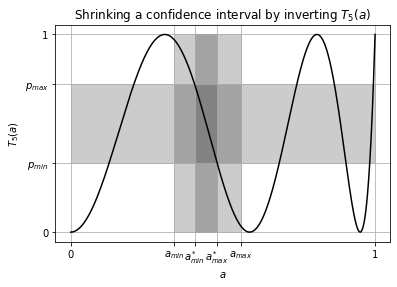

In [3]:
def plot_example_fig5():
    deg = 5
    a_min, a_max = 0.34, 0.56
    p_min, p_max = 0.35, 0.75
    
    # The midpoint of confidence interval is generally
    # a good choice for a_int because it is unlikely
    # to be at an extremum. This is because the 
    # Chebyshev polynomial was chosen so that [a_min,a_max]
    # is entirely on an increasing or decreasing portion.
    a_int = np.mean([a_min,a_max])
    
    a_min_star = invert(a_int,deg,p_min)
    a_max_star = invert(a_int,deg,p_max)
    
    a_min_star, a_max_star = sorted([a_min_star, a_max_star])
    
    a_vals = np.linspace(0,1,1000)
    plt.plot(a_vals, [cheb(deg,a)**2 for a in a_vals],c="k")
    
    plt.fill_between([a_min,a_max],[0,0],[1,1],alpha=0.2,color="k")
    plt.fill_between([a_min_star,a_max_star],
                     [0,0],[1,1],alpha=0.2,color="k")
    plt.fill_between([0,1],[p_min,p_min],
                     [p_max,p_max],alpha=0.2,color="k")

    
    plt.xticks([0,a_min,a_min_star,a_max_star,a_max,1],
               [0,"$a_{min}$","$a_{min}^*$",
                "$a_{max}^*$","$a_{max}$",1])
    
    plt.yticks([0,p_min,p_max,1],
               [0,"$p_{min}$","$p_{max}$",1])
    
    
    plt.title("Shrinking a confidence interval "+
              "by inverting $T_"+str(deg)+"(a)$")
    plt.xlabel("$a$")
    plt.ylabel("$T_"+str(deg)+"(a)$")
    plt.grid()
    
    

if True:
    plot_example_fig5()

## 2. find_next_cheb subroutine

This implementation has two features additional to the one listed in the paper:
 * We can provide a `min_deg`. If we can't find a good degree larger than this, then we just give up and return None. This saves some execution time.
 * If we set `odd=True`, then we restrict the search to odd polynomials only.

Other than that, this is extremely similar to the find_next_k subroutine from [arXiv:1912.05559](https://arxiv.org/abs/1912.05559). We were able to simplify the implementation due to the following chain of equivalences:

$$ \cos^2(d\theta) \text{ has no extrema for } \theta \in [\theta_{min}, \theta_{max}] $$
$$ \cos(2d\theta) \text{ has no extrema for } \theta \in [\theta_{min}, \theta_{max}] $$
$$ \cos(\theta') \text{ has no extrema for } \theta' \in [2d\theta_{min}, 2d\theta_{max}] $$
$$ [2d\theta_{min}, 2d\theta_{max}] \text{ contains no multiples of } \pi$$
$$ [2d\theta_{min}/\pi, 2d\theta_{max}/\pi] \text{ contains no integers}$$
$$ \text{floor}(2d\theta_{min}/\pi) = \text{floor}(2d\theta_{max}/\pi) $$



In [4]:

# find a deg > min_deg such that cheb(deg, a)**2 has no
# extrema for any a in [a_min,a_max]
def find_next_cheb(a_min, a_max, min_deg=0, odd=False):

    # Step 1: convert to theta.
    theta_lo = np.arccos(a_max)
    theta_hi = np.arccos(a_min)
    
    # Step 2: get highest possible degree.
    deg = int((np.pi/2)/(theta_hi-theta_lo))
    if odd and deg % 2 == 0: deg += 1

    # Step 3: search for the highest degree without any extrema.
    while deg > min_deg:
        
        if int(2*deg*theta_lo/np.pi) == int(2*deg*theta_hi/np.pi):
            # Done!
            return deg
        
        if odd: deg -= 2
        else: deg -= 1
            
    return None # Couldn't find a degree > min_deg.


## 3. Main algorithm

This implementation of the ChebAE algorithm has two additional flags:

* Setting `odd=True` forces find_next_cheb to consider odd polynomials only.
* Setting `IQAE_cutoff=True` uses IQAE's methodology for determining when to slow the sampling rate.




In [5]:

# Say we tossed a coin with unknown bias Nshots many times,
# and we want a confidence interval with confidence >= 1-delta.
# What is the widest that this interval could be?
# Relies on Clopper-Pearson confidence interval method.
def max_error_cp(delta, Nshots):
    max_error = 0
    
    # Loop over all possible numbers of heads.
    for counts in range(0,Nshots+1):
        lower,upper = proportion_confint(counts, Nshots,
                                         method="beta",
                                         alpha=delta)
        if (upper-lower)/2 > max_error:
            max_error = (upper-lower)/2
    
    return max_error
        
# IQAE's computation of the maximum error on theta.
# This seems to loop over many possible probabilities x.
# We could have optimized this, but we want to remain
# faithful to IQAE's implementation. 
# But we did add a cache to make it evaluate faster.
max_error_iqae_cache = {}
def max_error_iqae(delta_T, N_shots):
    if str([delta_T,N_shots]) in max_error_iqae_cache:
        return max_error_iqae_cache[str([delta_T,N_shots])]
    
    g_CP_y = []
    for x in np.linspace(0, 1, 10000):
        p_min, p_max = proportion_confint(int(x*N_shots), N_shots, method='beta', alpha=delta_T)
        g_CP_y.append(np.abs(np.arccos(1-2*p_max)-np.arccos(1-2*p_min))/2)
    out = np.max(g_CP_y)
    
    max_error_iqae_cache[str([delta_T,N_shots])] = out
    
    return out



In [6]:
def chebae(a_true, eps, delta,
           nu=8, r=2, Nshots=100,
           IQAE_cutoff=False, odd=False):

    # Step 1: determine the total number of confidence intervals
    # and distribute failure probability budget evenly among them
    T = int(np.ceil(np.log(1/(2*eps))/np.log(r)))
    delta_T = delta/T 

    
    # Step 2: precompute cutoff parameters.
    if IQAE_cutoff: L_max = max_error_iqae(delta_T, Nshots)
    else: err_max = max_error_cp(delta_T, Nshots)

        
    # Step 3: Initialize
    a_min, a_max = 0, 1 # confidence interval
    num_flips, num_heads = 0, 0 # coin toss tally    
    deg = 1 # degree
    queries = 0 # only count queries to Pi oracle

    
    # Step 4:
    while a_max - a_min > eps*2:

        # Step 4(a)
        # Try to find a better polynomial with degree > r*deg.
        new_deg = find_next_cheb(a_min, a_max,
                                 min_deg=deg*r,
                                 odd=odd)

        # Found a better polynomial? If so, reset the counts.
        if new_deg is not None:
            deg = new_deg
            num_flips, num_heads = 0, 0
            
        
        # Step 4(b): determine 'late' or 'early' to avoid taking too many samples
        # by setting N_shots_i - the number of shots in this iteration
        if IQAE_cutoff:
            # follow IQAE's implementation to decide when to reduce N_shots_i
            # deg = 2*k+1
            # K_i = 4*k+2 = 2*deg
            K_i = 2*deg
            eps_theta = eps / np.pi
            if K_i > int(L_max/eps_theta):
                Nshots_i = int((L_max/eps_theta)*Nshots/K_i/10)
                if Nshots_i == 0: Nshots_i = 1
            else:
                Nshots_i = Nshots
                
        else:
            gap = cheb(deg, a_max)**2 - cheb(deg, a_min)**2
            if err_max * (a_max - a_min)/gap < nu*eps:
                Nshots_i = 1      # late: sample one-at-a-time
            else:
                Nshots_i = Nshots # early: take lots of samples

        # Step 4(c): Simulate the quantum computer to toss coins
        prob = cheb(deg, a_true)**2
        for i in range(Nshots_i):
            if np.random.random() < prob: num_heads += 1
            num_flips += 1
            # final measurement doesn't count as a query,
            # to be consistent with 1912.05559's benchmarking
            queries += int(np.floor(deg/2))

        # Step 4(d): determine confidence interval for prob
        p_min, p_max = proportion_confint(num_heads, num_flips,
                                          method="beta",
                                          alpha=delta_T)
        
        # Step 4(e): back-propagate [p_min,p_max] to confidence
        # interval for [a_min_star, a_max_star] for a_true
        a_int = np.mean([a_min,a_max])
        a_min_star = invert(a_int,deg,p_min)
        a_max_star = invert(a_int,deg,p_max)
        a_min_star, a_max_star = sorted([a_min_star, a_max_star])

        # prevent floating point glitches
        a_min_star -= 1e-15
        a_max_star += 1e-15
        
        # Step 5(d): updat ethe interval
        a_min, a_max = max(a_min, a_min_star), min(a_max, a_max_star)

    # Status: did was a_true indeed in the confidence interval?
    # In other words, was the estimate actually accurate?
    status = bool((a_min <= a_true) and (a_true <= a_max))

    return {'queries': queries,
            'a_min': a_min,
            'a_max': a_max,
            'a_hat': np.mean([a_min,a_max]),
            'status': status}

## 4. Caching of collected data

In [7]:
cache_file = "data.json"


def get_samples(label, num_runs,
                a_true, log10_eps, delta,
                log2_nu=3, r=2, Nshots=100,
                IQAE_cutoff=False, odd=False):
    
    # Sanitize inputs:
    # To make sure that floating point glitches don't make
    # the same data point have different key strings, we round all the
    # inputs to 3 decimal places (or to an integer where suitable)
    num_runs = int(num_runs)
    a_true = np.round(float(a_true),3)
    log10_eps = np.round(float(log10_eps),3)
    delta = np.round(float(delta),3)
    log2_nu = np.round(float(log2_nu),3)
    r = np.round(float(r),3)
    Nshots = int(Nshots)

    requested_key = json.dumps([
        label, a_true, log10_eps, delta,
        log2_nu, r, Nshots, IQAE_cutoff, odd
    ])
        
    values = []
        
    # Try to find the key in the cache file.
    with open(cache_file) as f:
        for l in f.readlines():
            key,value = json.loads(l.strip())
            if key == requested_key: 
                values.append(value)
                if len(values) == num_runs:
                    return values
    
    # Not enough values? Sample them and append to cache.
    while len(values) < num_runs:
        print("Collecting {} of {}".format(len(values)+1, num_runs), end="\r")
        
        value = chebae(a_true, 10**log10_eps, delta,
                       nu=2**log2_nu, r=r, Nshots=Nshots,
                       IQAE_cutoff=IQAE_cutoff, odd=odd)
    
        values.append(value)
    
        # append to cache
        with open(cache_file,"a") as f:
            f.write(json.dumps([requested_key,value])+"\n")
    
    return values
    

## 5. Performance as a function of $\varepsilon$ (Figure 6)


To check that the failure rate isn't too high we conduct a statistical hypothesis test with the null hypothesis that the algorithm fails with probability $\leq \delta$. We take $n$ samples, and the test statistic is the number of failures $k$. If $ k > k_\text{tol}$ for some maximum tolerated number of failures $k_\text{tol}$. The probability that we make a type-1 error, that is, reject the null hypothesis even though it is true, is:
$$ \text{Pr}[ \text{fail more than }k_\text{tol} \text{ times} ] = 1-C_{\delta,n}(k_\text{tol}) = \alpha_\text{sig} $$
where $C_{\delta,n}(k_\text{tol})$ is the CDF of the binomial distribution. We set $\alpha_\text{sig} = 5\%$ throughout.


In [8]:

# compute the maximum number of failures we tolerate
def get_k_tol(n, delta, alpha_sig):
    k = 0
    while binom.cdf(k, n, delta) < 1-alpha_sig: k += 1
    return k-1


We tolerate 61 failures.
\eps = 10^-2.0
Failure count: 60 (GOOD)
\eps = 10^-2.5
Failure count: 32 (GOOD)
\eps = 10^-3.0
Failure count: 42 (GOOD)
\eps = 10^-3.5
Failure count: 48 (GOOD)
\eps = 10^-4.0
Failure count: 47 (GOOD)
\eps = 10^-4.5
Failure count: 53 (GOOD)
\eps = 10^-5.0
Failure count: 56 (GOOD)
\eps = 10^-5.5
Failure count: 58 (GOOD)
\eps = 10^-6.0
Failure count: 35 (GOOD)


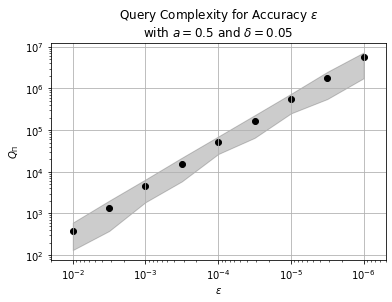

In [9]:

def plot_example_fig6():
    
    a_true = 0.5
    delta = 0.05
    num_runs = 1000
    
    alpha_sig = 0.05
    k_tol = get_k_tol(num_runs,delta,alpha_sig)
    print("We tolerate {} failures.".format(k_tol))
    
    log10_epss = -np.linspace(2,6,9)
    query_mins = []
    query_means = []
    query_maxs = []

    
    for log10_eps in log10_epss:
        print("\eps = 10^{}".format(log10_eps))
        
        # Collect / extract data
        values = get_samples("fig6", num_runs,
                             a_true, log10_eps, delta)
    
        
        # Check that we didn't fail too often.
        fail_count = sum([not v["status"] for v in values])
        print("Failure count: {} ({})".format(fail_count,
                        "GOOD" if fail_count <= k_tol else "BAD"))
        
        # Include only runs that didn't fail in query complexity.
        # The ones that failed often have unrepresentatively small complexity.
        queries = [v["queries"] for v in values if v["status"]]
        query_mins.append(min(queries))
        query_means.append(np.mean(queries))
        query_maxs.append(max(queries))

        
    epss = [10**(log10_eps) for log10_eps in log10_epss]
    plt.fill_between(epss, query_mins, query_maxs, color="k", alpha=0.2)
    plt.scatter(epss, query_means,c="k")
        
    plt.title("Query Complexity for Accuracy $\\varepsilon$\n"
             +"with $a={}$ and $\\delta={}$".format(a_true,delta))
    plt.ylabel("$Q_\Pi$")
    plt.xlabel("$\\varepsilon$")
    
    plt.grid()
    plt.yscale("log")
    plt.xscale("log")
    plt.xlim(max(epss)*2,min(epss)/2)
    

if True:
    plot_example_fig6()

## 6. Fits


In [10]:
def get_fit_data():
    log10_epss = -np.linspace(2,6,9)
    epss = [10**(log10_eps) for log10_eps in log10_epss]
    query_mins, query_means, query_maxs = [], [], []

    for log10_eps in log10_epss:
        values = get_samples("fig6", 1000,
                             0.5, log10_eps, 0.05)  
        queries = [v["queries"] for v in values if v["status"]]
        query_mins.append(min(queries))
        query_means.append(np.mean(queries))
        query_maxs.append(max(queries))
        
    return epss, query_mins, query_means, query_maxs


In [11]:

def two_param_model(eps,A,B):
    return A * eps**(-1) * np.log( B * np.log( eps**(-1) ) )

def two_parameter_fits():
    epss, query_mins, query_means, query_maxs = get_fit_data()
    
    best_AB, best_err = None, None
    for A in np.arange(1,10,0.01) :
        for B in np.arange(1,10,0.01):
            err = max( np.abs(1 - q/two_param_model(eps,A,B))  
                       for (eps,q) in zip(epss,query_means))
            if best_AB is None or best_err > err:
                best_AB = (A,B)
                best_err = err
    
    A,B = best_AB
    print("Best fit parameters: A={:.2f}, B={:.2f}".format(A,B))
    print("Maximum deviation of mean from fit:",  np.round(best_err*100,2), "%")
          
    maxerr = max( np.abs(1 - q/two_param_model(eps,A,B))  
                for (eps,q) in zip(epss,query_maxs))
    minerr = max( np.abs(1 - q/two_param_model(eps,A,B))  
                for (eps,q) in zip(epss,query_mins))   
    print("Maximum deviation of any query count from fit:",
              np.round(max(maxerr,minerr)*100,2), "%")

if True:
    two_parameter_fits()


Best fit parameters: A=1.71, B=2.08
Maximum deviation of mean from fit: 3.15 %
Maximum deviation of any query count from fit: 71.77 %


In [12]:
def one_param_model(eps,C):
    return C * eps**(-1)

def one_parameter_fits():
    epss, query_mins, query_means, query_maxs = get_fit_data()
    
    best_C, best_err = None, None
    for C in np.arange(1,10,0.01) :
        err = max( np.abs(1 - q/one_param_model(eps,C))  
                   for (eps,q) in zip(epss,query_means))
        if best_C is None or best_err > err:
            best_C = C
            best_err = err
    
    C = best_C
    print("Best fit parameter: C={:.2f}".format(C))
    print("Maximum deviation of mean from fit:", np.round(best_err*100,2), "%")
          
    maxerr = max( np.abs(1 - q/one_param_model(eps,C))  
                for (eps,q) in zip(epss,query_maxs))
    minerr = max( np.abs(1 - q/one_param_model(eps,C))  
                for (eps,q) in zip(epss,query_mins))   
    print("Maximum deviation of any query count from fit:", 
              np.round(max(maxerr,minerr)*100,2), "%")

if True:
    one_parameter_fits()

Best fit parameter: C=4.66
Maximum deviation of mean from fit: 19.65 %
Maximum deviation of any query count from fit: 74.28 %


## 7. Performance as a function of $\nu$ (Figure 7)


We tolerate 14 failures.
IQAE Cutoff (all degrees)
Failure count: 3 (GOOD)
IQAE Cutoff (odd degrees)
Failure count: 4 (GOOD)
nu = 2^-3 (all degrees)
Failure count: 8 (GOOD)
nu = 2^-3 (odd degrees)
Failure count: 7 (GOOD)
nu = 2^-2 (all degrees)
Failure count: 5 (GOOD)
nu = 2^-2 (odd degrees)
Failure count: 5 (GOOD)
nu = 2^-1 (all degrees)
Failure count: 9 (GOOD)
nu = 2^-1 (odd degrees)
Failure count: 7 (GOOD)
nu = 2^0 (all degrees)
Failure count: 6 (GOOD)
nu = 2^0 (odd degrees)
Failure count: 14 (GOOD)
nu = 2^1 (all degrees)
Failure count: 13 (GOOD)
nu = 2^1 (odd degrees)
Failure count: 5 (GOOD)
nu = 2^2 (all degrees)
Failure count: 8 (GOOD)
nu = 2^2 (odd degrees)
Failure count: 12 (GOOD)
nu = 2^3 (all degrees)
Failure count: 13 (GOOD)
nu = 2^3 (odd degrees)
Failure count: 12 (GOOD)


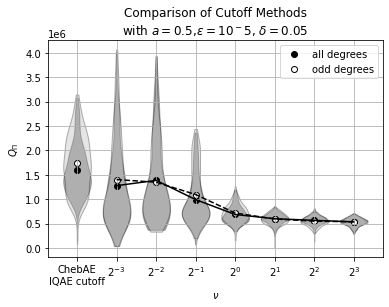

In [13]:

def plot_example_fig7():
    
    a_true = 0.5
    log10_eps = -5
    delta = 0.05
    num_runs = 200

    alpha_sig = 0.05
    k_tol = get_k_tol(num_runs,delta,alpha_sig)
    print("We tolerate {} failures.".format(k_tol))
    
    queries_all = []
    queries_odd = []

    for odd in [False,True]:
        print("IQAE Cutoff ({} degrees)".format("odd" if odd else "all"))
        values = get_samples("fig7", num_runs, a_true, log10_eps, delta,
                             IQAE_cutoff=True, odd=odd)    
        fail_count = sum([not v["status"] for v in values])
        print("Failure count: {} ({})".format(fail_count,
                        "GOOD" if fail_count <= k_tol else "BAD"))
        if odd: queries_odd.append([v["queries"] for v in values])
        else: queries_all.append([v["queries"] for v in values])

    log2_nus = [-3,-2,-1,0,1,2,3]
    for log2_nu in log2_nus:
        for odd in [False,True]:
            print("nu = 2^{} ({} degrees)".format(log2_nu, "odd" if odd else "all"))
            values = get_samples("fig7", num_runs, a_true, log10_eps, delta,
                                 log2_nu=log2_nu, IQAE_cutoff=False, odd=odd)    
            fail_count = sum([not v["status"] for v in values])
            print("Failure count: {} ({})".format(fail_count,
                        "GOOD" if fail_count <= k_tol else "BAD"))
            if odd: queries_odd.append([v["queries"] for v in values])
            else: queries_all.append([v["queries"] for v in values])
    

    violin_parts_all = plt.violinplot(queries_all, range(len(log2_nus)+1), widths=0.7, showextrema=False)
    for pc in violin_parts_all['bodies']:
        pc.set_facecolor("black")
        pc.set_edgecolor('black')

    violin_parts_odd = plt.violinplot(queries_odd, range(len(log2_nus)+1), widths=0.7, showextrema=False)
    for pc in violin_parts_odd['bodies']:
        pc.set_facecolor("#aaaaaa")
        pc.set_edgecolor('black')
    
    plt.scatter(range(len(log2_nus)+1), [np.mean(q) for q in queries_all],c="k",label="all degrees")
    plt.scatter(range(len(log2_nus)+1), [np.mean(q) for q in queries_odd],c="w",edgecolors="k",label="odd degrees")

    plt.plot(range(1,len(log2_nus)+1), [np.mean(q) for q in queries_all[1:]],c="k")
    plt.plot(range(1,len(log2_nus)+1), [np.mean(q) for q in queries_odd[1:]],c="k",linestyle="--")
    
    plt.title("Comparison of Cutoff Methods\n"
             +"with $a={}$,".format(a_true)
             +"$\\varepsilon=10^{}$, $\\delta={}$".format(log10_eps,delta))
  
    plt.ylabel("$Q_\Pi$")
    plt.xlabel("$\\nu$")
    plt.legend()
    
    plt.xticks(range(len(log2_nus)+1), ["ChebAE\nIQAE cutoff"]
               + ["$2^{"+str(log2_nu)+"}$" for log2_nu in log2_nus])
    plt.grid()

    plt.show()
    

if True:
    plot_example_fig7()

## 8. Performance as a function of $a$ (Figure 8)


We tolerate 61 failures.
a = 0.1
Failure count: 22 (GOOD)
a = 0.2
Failure count: 29 (GOOD)
a = 0.30000000000000004
Failure count: 22 (GOOD)
a = 0.4
Failure count: 27 (GOOD)
a = 0.5
Failure count: 52 (GOOD)
a = 0.6
Failure count: 39 (GOOD)
a = 0.7000000000000001
Failure count: 31 (GOOD)
a = 0.8
Failure count: 23 (GOOD)
a = 0.9
Failure count: 29 (GOOD)


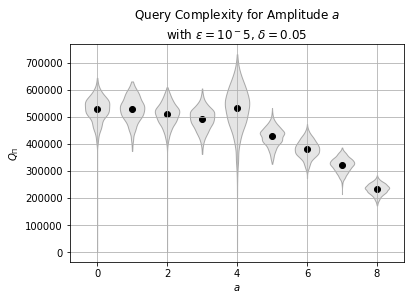

In [15]:

def plot_example_fig8():
    
    log10_eps = -5
    delta = 0.05
    num_runs = 1000

    alpha_sig = 0.05
    k_tol = get_k_tol(num_runs,delta,alpha_sig)
    print("We tolerate {} failures.".format(k_tol))
    
    a_trues = np.arange(0.1,1.0,0.1)
    queries = []

    for a_true in a_trues:
        print("a = {}".format(a_true))
        values = get_samples("fig8", num_runs, a_true, log10_eps, delta)    
        fail_count = sum([not v["status"] for v in values])
        print("Failure count: {} ({})".format(fail_count,
                    "GOOD" if fail_count <= k_tol else "BAD"))
        queries.append([v["queries"] for v in values])
    
    violin_parts = plt.violinplot(queries, range(len(a_trues)),
                                  widths=0.7, showextrema=False)
    for pc in violin_parts['bodies']:
        pc.set_facecolor("#aaaaaa")
        pc.set_edgecolor('black')
    
    plt.scatter(range(len(a_trues)), [np.mean(q) for q in queries],c="k")

    plt.title("Query Complexity for Amplitude $a$\n"
             +"with $\\varepsilon=10^{}$, $\\delta={}$".format(log10_eps,delta))
  
    plt.ylabel("$Q_\Pi$")
    plt.xlabel("$a$")
    plt.grid()

    plt.show()
    

if True:
    plot_example_fig8()